# Prepare Environment

Load necessary modules and attempt to compile the GrOpt library if it isn't already

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from timeit import default_timer as timer

# This attempts to re-compile the library in case it has been changed, mostly for debug, but won't do anything
# if nothing is changed
import subprocess
out = subprocess.run(["python", "setup.py", "build_ext", "--inplace"], stdout=subprocess.PIPE)
import gropt

from helper_utils import *

%matplotlib inline

# M0 Nulled CODE

Generate a waveform with $M_0 = 0$, other parameters as listed in the code.

TE was manually selected (44.4 ms) to hit b-value = 600

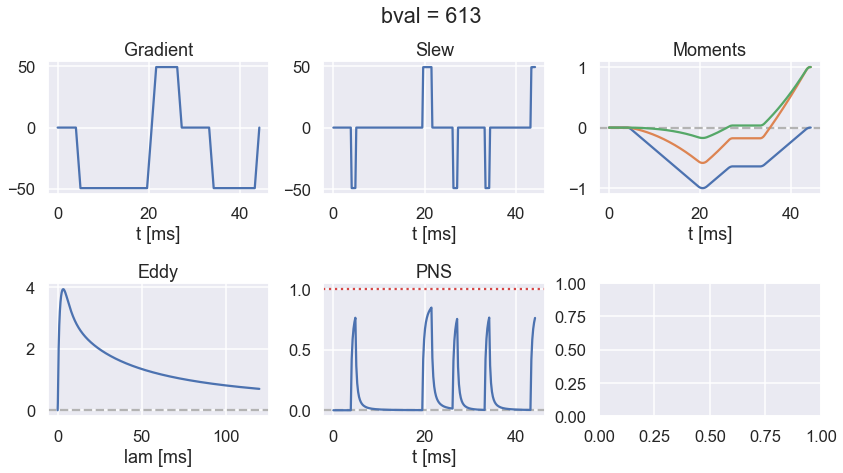

In [2]:
params = {}
params['mode'] = 'diff_bval'
params['gmax']  = 0.05
params['smax']  = 50.0
params['MMT']  = 0
params['TE']  = 60.5
params['T_readout']  = 16.0
params['T_90']  = 4.0
params['T_180']  = 6.0
params['dt']  = 200e-6

G, dd = gropt.gropt(params, verbose=1)

plot_waveform(G, params['TE'], params['T_readout'])

# M0+M1 Nulled CODE

Generate a waveform with $M_0 = 0$ and $M_1 = 0$, other parameters as listed in the code.

TE was manually selected (82 ms) to hit b-value = 600

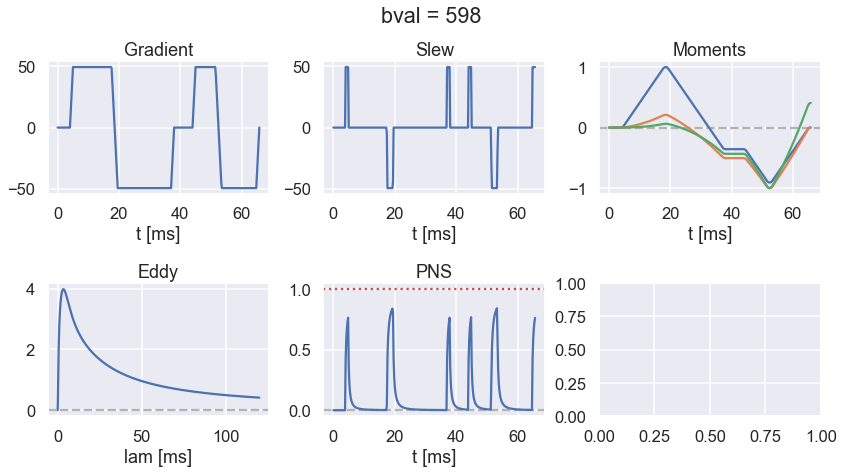

In [9]:
params = {}
params['mode'] = 'diff_bval'
params['gmax']  = 0.05
params['smax']  = 50.0
params['MMT']  = 1
params['TE']  = 82.0
params['T_readout']  = 16.0
params['T_90']  = 4.0
params['T_180']  = 6.0
params['dt']  = 200e-6

G, dd = gropt.gropt(params, verbose=1)

plot_waveform(G, params['TE'], params['T_readout'])

# M0+M1+M2 Nulled CODE

Generate a waveform with $M_0 = 0$, $M_1 = 0$ and $M_2 = 0$, other parameters as listed in the code.

TE was manually selected (97 ms) to hit b-value = 600

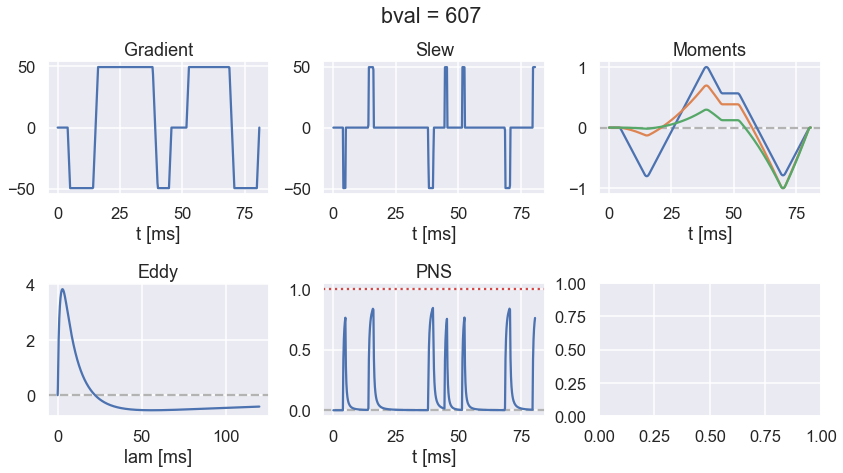

In [15]:
params = {}
params['mode'] = 'diff_bval'
params['gmax']  = 0.05
params['smax']  = 50.0
params['MMT']  = 2
params['TE']  = 97.0
params['T_readout']  = 16.0
params['T_90']  = 4.0
params['T_180']  = 6.0
params['dt']  = 200e-6

G, dd = gropt.gropt(params, verbose=1)

plot_waveform(G, params['TE'], params['T_readout'])